In [2]:

import tensorflow as tf
import os
import numpy as np
import pandas as pd
import glob

In [3]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
images = sorted(glob.glob('/content/drive/MyDrive/Flood_DataSet/Flood_dataset/Image/*.jpg'))
masks = sorted(glob.glob('/content/drive/MyDrive/Flood_DataSet/Flood_dataset/Mask/*.png'))
len(images), len(masks)

(290, 290)

In [5]:
import numpy as np
import cv2
import os
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

class CustomDataGenerator(keras.utils.Sequence):
    def __init__(self, images, masks, batch_size=8, img_size=(512, 512), shuffle=True):
        self.batch_size = batch_size
        self.img_size = img_size
        self.shuffle = shuffle
        self.images = images #os.listdir(image_folder)
        self.masks = masks #os.listdir(mask_folder)

        # on each epoch end, shuffle the dataset
        self.on_epoch_end()

        # datagen function to augment the input image and mask pair
        self.datagen = ImageDataGenerator(
            rotation_range=5,
            width_shift_range=0.1,
            height_shift_range=0.1,
            zoom_range=0.05,
            horizontal_flip=True,
            vertical_flip=True,
            fill_mode = 'constant',
            cval=0.0,
        )
            # randomly crop the images to 512x512 size
    def random_crop(self, image, mask, crop_size=512):

        # image width and height calculation
        img_height, img_width = image.shape[0], image.shape[1]
        mask_height, mask_width = mask.shape[0], mask.shape[1]

        # random x and y coordinate for cropping the image
        x = np.random.randint(0, img_width - crop_size)
        y = np.random.randint(0, img_height - crop_size)

        # random crop
        image_crop = image[y:y + crop_size, x:x + crop_size, :]
        mask_crop = mask[y:y + crop_size, x:x + crop_size]

        return image_crop, mask_crop

    # data augmentation using keras ImageDataGenerator function
    def data_augmentation(self, image, mask):
        trans_param = self.datagen.get_random_transform(image.shape)
        image = self.datagen.apply_transform(image, trans_param)
        mask = self.datagen.apply_transform(mask, trans_param)
        return image, mask

    # length of the processing batch
    def __len__(self):
        return int(np.ceil(len(self.images) / self.batch_size))

    # data normalization
    def data_normalization(self, image, mask):

        # reshape mask from 512x512 to 512x512x1
        mask = mask.reshape((*self.img_size, 1))
        mask = np.where(mask<127, 0, 1)

        # data normalization
        image = image / 255.0

        # return image and mask
        return image, mask

    # data preprocessing, resize, crop image etc
    def data_preprocessing(self, image, mask):
        image, mask = cv2.resize(image, (576, 576)), cv2.resize(mask, (576, 576))
        image, mask = self.random_crop(image, mask)
        return image, mask

    # on each epoch, shuffle the dataset (image and mask index)
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.images))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    # get item is the core function
    # this function will run in each batch/epoch to load the dataset into RAM and pass to DL model
    def __getitem__(self, index):

        # start and end index
        # the last index can be shorter than the number of batches
        start_idx = index * self.batch_size
        end_idx = min((index + 1) * self.batch_size, len(self.images))
        indexes = self.indexes[start_idx:end_idx]

        # initialize the images and mask batches
        batch_images = []
        batch_masks = []

    # iterate over each indexes in batch
        for i in indexes:
            img_path = self.images[i]
            mask_path = self.masks[i]

            # read image using open cv
            img = cv2.imread(img_path)
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

            # Skip if image or mask is not loaded properly
            if img is None or mask is None:
                continue

            # image preprocessing; resize, random crop
            img, mask = self.data_preprocessing(img, mask)

            # data normalization
            img, mask = self.data_normalization(img, mask)

            # data augmentation
            img, mask = self.data_augmentation(img, mask)

            # to fix the issue during training process
            mask = mask.astype(np.float32)

            # append each image, mask pair to the batches
            batch_images.append(img)
            batch_masks.append(mask)

        # return batch image and batch mamks as a numpy array (n, tile_x, tile_y, channels)
        return np.array(batch_images), np.array(batch_masks)

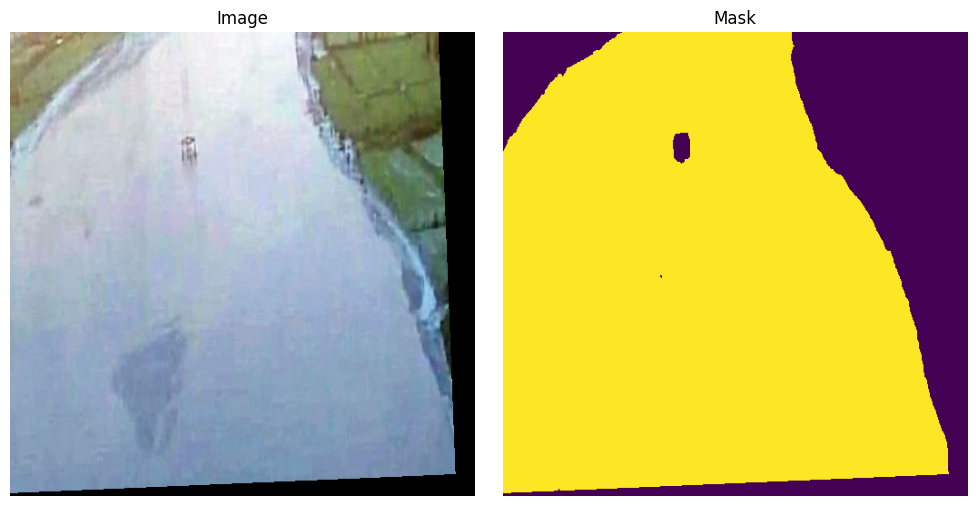

In [6]:
import matplotlib.pyplot as plt

data = CustomDataGenerator(images, masks)
batch_images, batch_masks = data.__getitem__(0)

img = np.random.randint(0,8)
# Visualize the first image and its mask from the batch
image = batch_images[img]
mask = batch_masks[img]

# Plotting the image and its mask
plt.figure(figsize=(10, 5))

# Display Image
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title('Image')
plt.axis('off')

# Display Mask
plt.subplot(1, 2, 2)
plt.imshow(mask)
plt.title('Mask')
plt.axis('off')

plt.tight_layout()
plt.show()

In [7]:
from sklearn.model_selection import train_test_split
train_img, test_img, train_mask, test_mask = train_test_split(images, masks, test_size=0.2, random_state=42)

In [8]:
len(train_img), len(test_img)

(232, 58)

In [9]:
train_dataset = CustomDataGenerator(train_img, train_mask)
test_dataset = CustomDataGenerator(test_img, test_mask)

In [10]:
import tensorflow as tf
from tensorflow.keras import backend as K

# recall
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

# precision
def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

#f1 score
def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def dsc(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return score

def dice_loss(y_true, y_pred):
    loss = 1 - dsc(y_true, y_pred)
    return loss

In [11]:
import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Conv2D, UpSampling2D, MaxPooling2D,
    BatchNormalization, Activation, Add, Multiply, Concatenate
)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy

# Function to create a convolutional block
def conv_block(x, filters, name, batch_norm=True):
    x = Conv2D(filters, (3, 3), padding="same", kernel_initializer="he_normal", name=name + "_conv1")(x)
    if batch_norm:
        x = BatchNormalization(name=name + "_bn1")(x)
    x = Activation("relu", name=name + "_act1")(x)

    x = Conv2D(filters, (3, 3), padding="same", kernel_initializer="he_normal", name=name + "_conv2")(x)
    if batch_norm:
        x = BatchNormalization(name=name + "_bn2")(x)
    x = Activation("relu", name=name + "_act2")(x)

    return x

# Function to create the attention gate (Ensuring correct shapes)
def attention_gate(x, g, inter_filters, name):
    theta_x = Conv2D(inter_filters, (1, 1), padding="same", name=name + "_theta")(x)
    phi_g = Conv2D(inter_filters, (1, 1), padding="same", name=name + "_phi")(g)

    attn_add = Add(name=name + "_add")([theta_x, phi_g])
    attn_relu = Activation("relu", name=name + "_relu")(attn_add)
    attn_conv = Conv2D(1, (1, 1), padding="same", activation="sigmoid", name=name + "_attn_conv")(attn_relu)

    attn_out = Multiply(name=name + "_multiply")([x, attn_conv])

    return attn_out

# Function to create the Attention U-Net model
def attn_unet(lr=0.001, loss_fn=binary_crossentropy, input_size=(512, 512, 3)):
    inputs = Input(input_size)

    # Encoder (Down-sampling)
    c1 = conv_block(inputs, 64, "enc1")
    p1 = MaxPooling2D(pool_size=(2, 2), name="pool1")(c1)

    c2 = conv_block(p1, 128, "enc2")
    p2 = MaxPooling2D(pool_size=(2, 2), name="pool2")(c2)

    c3 = conv_block(p2, 256, "enc3")
    p3 = MaxPooling2D(pool_size=(2, 2), name="pool3")(c3)

    c4 = conv_block(p3, 512, "enc4")
    p4 = MaxPooling2D(pool_size=(2, 2), name="pool4")(c4)

    c5 = conv_block(p4, 1024, "bottleneck")

    # Decoder (Up-sampling)
    up6 = UpSampling2D(size=(2, 2), name="up6")(c5)
    attn6 = attention_gate(c4, up6, 512, "attn6")
    merge6 = Concatenate(name="merge6")([attn6, up6])
    c6 = conv_block(merge6, 512, "dec6")

    up7 = UpSampling2D(size=(2, 2), name="up7")(c6)
    attn7 = attention_gate(c3, up7, 256, "attn7")
    merge7 = Concatenate(name="merge7")([attn7, up7])
    c7 = conv_block(merge7, 256, "dec7")

    up8 = UpSampling2D(size=(2, 2), name="up8")(c7)
    attn8 = attention_gate(c2, up8, 128, "attn8")
    merge8 = Concatenate(name="merge8")([attn8, up8])
    c8 = conv_block(merge8, 128, "dec8")

    up9 = UpSampling2D(size=(2, 2), name="up9")(c8)
    attn9 = attention_gate(c1, up9, 64, "attn9")
    merge9 = Concatenate(name="merge9")([attn9, up9])
    c9 = conv_block(merge9, 64, "dec9")

    # Output layer
    outputs = Conv2D(1, (1, 1), activation="sigmoid", name="output")(c9)

    # Compile the model
    model = Model(inputs=inputs, outputs=outputs, name="Attention_U-Net")
    model.compile(optimizer=Adam(learning_rate=lr), loss=loss_fn, metrics=["accuracy"])

    return model

# Initialize the model
model = attn_unet()
model.summary()


Model: "Attention_U-Net"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 512, 512, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ enc1_conv1 (Conv2D)       │ (None, 512, 512, 64)   │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ enc1_bn1                  │ (None, 512, 512, 64)   │            256 │ enc1_conv1[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ enc1_act1 (Activation)    │ (None, 512, 512, 64)   │              0 │ enc1_bn1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ enc1_conv2 (Conv2D)       │ (None, 512, 512, 64)   │         36,928 │ enc1_act1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ enc1_bn2                  │ (None, 512, 512, 64)   │            256 │ enc1_conv2[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ enc1_act2 (Activation)    │ (None, 512, 512, 64)   │              0 │ enc1_bn2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, 256, 256, 64)   │              0 │ enc1_act2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ enc2_conv1 (Conv2D)       │ (None, 256, 256, 128)  │         73,856 │ pool1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ enc2_bn1                  │ (None, 256, 256, 128)  │            512 │ enc2_conv1[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ enc2_act1 (Activation)    │ (None, 256, 256, 128)  │              0 │ enc2_bn1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ enc2_conv2 (Conv2D)       │ (None, 256, 256, 128)  │        147,584 │ enc2_act1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ enc2_bn2                  │ (None, 256, 256, 128)  │            512 │ enc2_conv2[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ enc2_act2 (Activation)    │ (None, 256, 256, 128)  │              0 │ enc2_bn2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool2 (MaxPooling2D)      │ (None, 128, 128, 128)  │              0 │ enc2_act2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ enc3_conv1 (Conv2D)       │ (None, 128, 128, 256)  │        295,168 │ pool2[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ enc3_bn1                  │ (None, 128, 128, 256)  │          1,024 │ enc3_conv1[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├──────────────────────

 Total params: 32,449,861 (123.79 MB)

 Trainable params: 32,438,085 (123.74 MB)

 Non-trainable params: 11,776 (46.00 KB)

In [ ]:
# callback functions
checkpointer = tf.keras.callbacks.ModelCheckpoint(f"/content/drive/MyDrive/dl/flood/flood_best.h5", monitor="val_f1_m", verbose=1, save_best_only=True, mode="max")
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_f1_m', patience=5, verbose=1, mode='max')

callbacks = [
    earlyStopping,
    checkpointer
    ]

# model training
history = model.fit(train_dataset,epochs=50,
                    verbose = 1,
                    # validation_split=0.15,
                    validation_data=test_dataset,
                    callbacks=callbacks)

# save the model weights at the end of the training process
model.save(f"/content/drive/MyDrive/dl/flood/flood_save.h5")


Epoch 1/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 286s 4s/step - accuracy: 0.7621 - loss: 0.4811 - val_accuracy: 0.6325 - val_loss: 1529.4094
Epoch 2/50


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_f1_m` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss
  current = self.get_monitor_value(logs)
/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:209: UserWarning: Can save best model only with val_f1_m available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


29/29 ━━━━━━━━━━━━━━━━━━━━ 80s 3s/step - accuracy: 0.8367 - loss: 0.3843 - val_accuracy: 0.5317 - val_loss: 33.7013
Epoch 3/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 79s 3s/step - accuracy: 0.8364 - loss: 0.3803 - val_accuracy: 0.3898 - val_loss: 3.0140
Epoch 4/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 80s 3s/step - accuracy: 0.8549 - loss: 0.3419 - val_accuracy: 0.4960 - val_loss: 2.3339
Epoch 5/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 79s 3s/step - accuracy: 0.8679 - loss: 0.3198 - val_accuracy: 0.5016 - val_loss: 1.8165
Epoch 6/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 79s 3s/step - accuracy: 0.8596 - loss: 0.3321 - val_accuracy: 0.5404 - val_loss: 1.3960
Epoch 7/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 79s 3s/step - accuracy: 0.8502 - loss: 0.3399 - val_accuracy: 0.7563 - val_loss: 0.5811
Epoch 8/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 79s 3s/step - accuracy: 0.8745 - loss: 0.3079 - val_accuracy: 0.7323 - val_loss: 0.7561
Epoch 9/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 79s 3s/step - accuracy: 0.8761 - loss: 0.3021 - val_accuracy: 0.8340 - val_loss: 0.4037
Ep

In [12]:
from keras.models import load_model

# Define the custom loss function before loading the model
custom_objects = {"f1_m": f1_m, 'precision_m': precision_m, 'recall_m': recall_m, 'dsc': dsc}

model = load_model('/content/drive/MyDrive/dl/flood/flood_save.h5', custom_objects=custom_objects)

In [13]:
import glob
imgs = glob.glob('/content/drive/MyDrive/Flood_DataSet/Flood_dataset/Image/*.jpg')

img_test = np.zeros((290, 512, 512,3))
#print(imgs)
for index, i in enumerate(imgs):
  img = cv2.imread(i)
  img = cv2.resize(img, (512, 512))
  img = img / 255.0
  # print(img.shape)
  img_test[index] = img


In [14]:
import glob
import random
from sklearn.model_selection import train_test_split

# Define dataset paths
IMAGE_PATH = "/content/drive/MyDrive/Flood_DataSet/Flood_dataset/Image/"
MASK_PATH = "/content/drive/MyDrive/Flood_DataSet/Flood_dataset/Mask/"

# Get all images and masks
images = sorted(glob.glob(IMAGE_PATH + "*.jpg"))  # Adjust extension if needed
masks = sorted(glob.glob(MASK_PATH + "*.png"))  # Adjust extension if needed

# Split dataset (80% train, 20% test)
train_images, test_images, train_masks, test_masks = train_test_split(images, masks, test_size=0.2, random_state=42)

# Verify dataset split
print(f"Total Images: {len(images)} | Training: {len(train_images)} | Testing: {len(test_images)}")
print(f"Total Masks: {len(masks)} | Training: {len(train_masks)} | Testing: {len(test_masks)}")


Total Images: 290 | Training: 232 | Testing: 58
Total Masks: 290 | Training: 232 | Testing: 58


1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


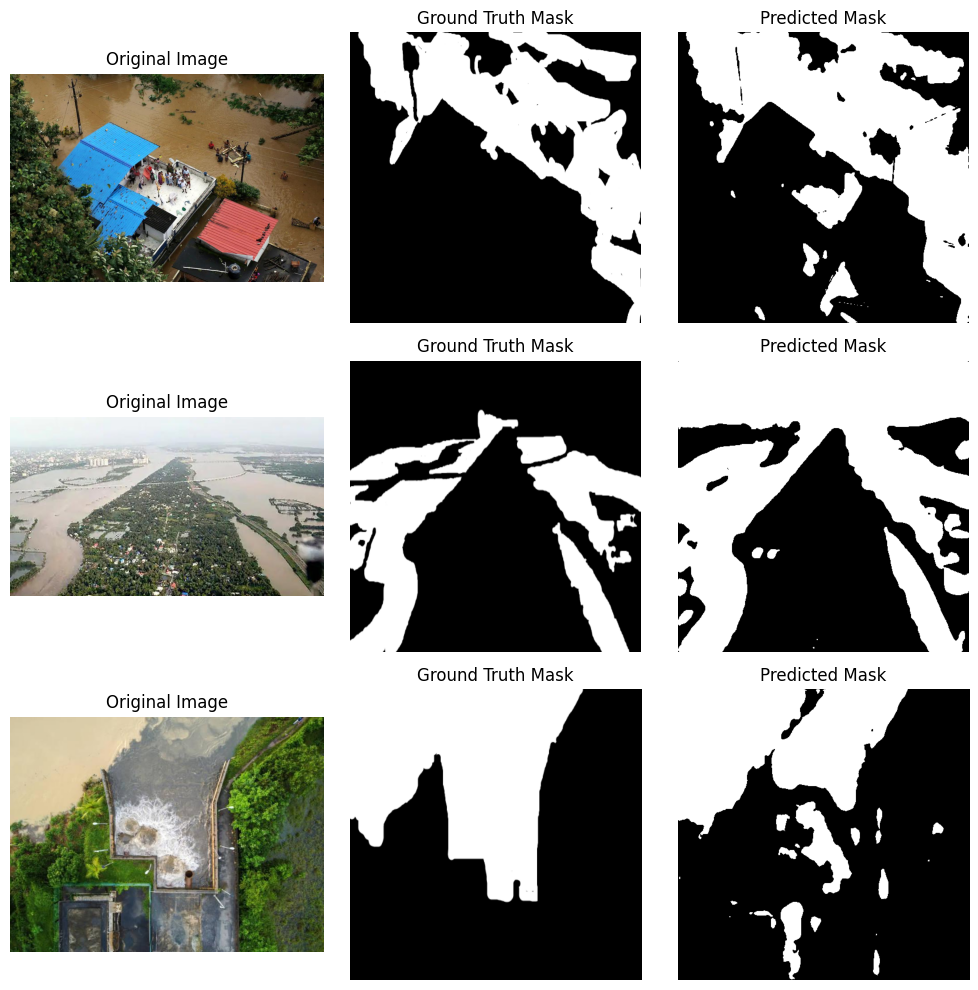

In [19]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random

def predict_random_images(model, test_images, test_masks):
    """ Selects 3 random test images, predicts their masks, and displays them. """

    selected_indices = random.sample(range(len(test_images)), 3)  # Select 3 random images

    fig, axes = plt.subplots(3, 3, figsize=(10, 10))

    for i, idx in enumerate(selected_indices):
        img_path = test_images[idx]
        mask_path = test_masks[idx]

        # Load and preprocess image
        image = cv2.imread(img_path)
        image = cv2.resize(image, (512, 512))
        image = image / 255.0  # Normalize
        image = np.expand_dims(image, axis=0)  # Add batch dimension

        # Load and preprocess mask
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, (512, 512))

        # Predict mask
        pred_mask = model.predict(image)[0]  # Get first image in batch
        pred_mask = (pred_mask > 0.5).astype(np.uint8)  # Threshold for binary mask

        # Display images
        axes[i, 0].imshow(cv2.imread(img_path)[:, :, ::-1])
        axes[i, 0].set_title("Original Image")
        axes[i, 1].imshow(mask, cmap="gray")
        axes[i, 1].set_title("Ground Truth Mask")
        axes[i, 2].imshow(pred_mask, cmap="gray")
        axes[i, 2].set_title("Predicted Mask")

        for ax in axes[i]:
            ax.axis("off")

    plt.tight_layout()
    plt.show()

# Run predictions
predict_random_images(model, test_images, test_masks)
